In [1]:
from model import *
from data import *
from helpers import *

In [19]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.nn.utils.prune
import pytorch_lightning as pl
from data import *

# Enocder class
class Encoder(pl.LightningModule):
    """
    Neural network used as encoder
    """
    def __init__(self,
                 nitems: int,
                 latent_dims: int,
                 hidden_layer_size: int,
                 hidden_layer_size2: int):
        """
        Initialisation
        :param latent_dims: number of latent dimensions of the model
        """
        super(Encoder, self).__init__()

        input_layer = nitems

        self.dense1 = nn.Linear(input_layer, hidden_layer_size)
        self.dense2 = nn.Linear(hidden_layer_size, hidden_layer_size2)
        self.densem = nn.Linear(hidden_layer_size2, latent_dims)
        self.denses = nn.Linear(hidden_layer_size2, latent_dims)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        A forward pass though the encoder network
        :param x: a tensor representing a batch of response data
        :param m: a mask representing which data is missing
        :return: a sample from the latent dimensions
        """

        # calculate s and mu based on encoder weights
        out = F.elu(self.dense1(x))
        out = F.elu(self.dense2(out))
        mu =  self.densem(out)
        log_sigma = self.denses(out)

        return mu, log_sigma

# Sampling layer
class SamplingLayer(pl.LightningModule):
    def __init__(self):
        super(SamplingLayer, self).__init__()
        self.N = torch.distributions.Normal(0, 1)

    def forward(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        error = self.N.sample(mu.shape)
        # potentially move error vector to GPU
        error = error.to(mu)
        return mu + sigma * error

# Decoder class
class Decoder(pl.LightningModule):
    """
    Neural network used as decoder
    """

    def __init__(self, nitems: int, latent_dims: int):
        """
        Initialisation
        :param latent_dims: the number of latent factors
        :param qm: IxD Q-matrix specifying which items i<I load on which dimensions d<D
        """
        super().__init__()

        # initialise netowrk components
        input_layer = latent_dims
        self.linear = nn.Linear(input_layer, nitems)
        self.activation = nn.Sigmoid()


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass though the network
        :param x: tensor representing a sample from the latent dimensions
        :param m: mask representing which data is missing
        :return: tensor representing reconstructed item responses
        """
        out = self.linear(x)
        out = self.activation(out)
        return out
    
# Decoder class
class Decoder_Normal(pl.LightningModule):
    """
    Neural network used as decoder
    """

    def __init__(self, nitems: int, latent_dims: int):
        """
        Initialisation
        :param latent_dims: the number of latent factors
        :param qm: IxD Q-matrix specifying which items i<I load on which dimensions d<D
        """
        super().__init__()

        # initialise netowrk components
        input_layer = latent_dims
        self.linear = nn.Linear(input_layer, nitems)
        self.activation = nn.Sigmoid()


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass though the network
        :param x: tensor representing a sample from the latent dimensions
        :param m: mask representing which data is missing
        :return: tensor representing reconstructed item responses
        """
        out = self.linear(x)
        return out

# Entire variational autoencoder class
class VAE(pl.LightningModule):
    """
    Neural network for the entire variational autoencoder
    """
    def __init__(self,
                 dataloader,
                 nitems: int,
                 latent_dims: int,
                 hidden_layer_size: int,
                 hidden_layer_size2: int,
                 learning_rate: float,
                 batch_size: int,
                 beta: int = 1):
        """
        Initialisaiton
        :param latent_dims: number of latent dimensions
        """
        super(VAE, self).__init__()
        #self.automatic_optimization = False
        self.nitems = nitems
        self.dataloader = dataloader

        self.encoder = Encoder(nitems,
                               latent_dims,
                               hidden_layer_size,
                               hidden_layer_size2
        )

        self.sampler = SamplingLayer()

        self.decoder = Decoder(nitems, latent_dims)

        self.lr = learning_rate
        self.batch_size = batch_size
        self.beta = beta
        self.kl=0

    def forward(self, x: torch.Tensor):
        """
        forward pass though the entire network
        :param x: tensor representing response data
        :param m: mask representing which data is missing
        :return: tensor representing a reconstruction of the input response data
        """
        mu, log_sigma = self.encoder(x)
        z = self.sampler(mu, log_sigma)
        reco = self.decoder(z)

        # calcualte kl divergence
        kl = 1 + 2 * log_sigma - torch.square(mu) - torch.exp(2 * log_sigma)
        kl = torch.sum(kl, dim=-1)
        self.kl = -.5 * torch.mean(kl)
        return reco

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, amsgrad=True)

    def training_step(self, batch, batch_idx):
        # forward pass

        data, mask = batch
        X_hat = self(data)

        # calculate the likelihood, and take the mean of all non missing elements
        # bce = data * torch.log(X_hat) + (1 - data) * torch.log(1 - X_hat)
        # bce = bce*mask
        # bce = -self.nitems * torch.mean(bce, 1)
        # bce = bce / torch.mean(mask.float(),1)

        bce = torch.nn.functional.binary_cross_entropy(X_hat, batch[0], reduction='none')
        bce = torch.mean(bce)  * self.nitems
        bce = bce / torch.mean(mask.float())

        # sum the likelihood and the kl divergence

        #loss = torch.mean((bce + self.encoder.kl))
        loss = bce + self.beta * self.kl
        #self.log('binary_cross_entropy', bce)
        #self.log('kl_divergence', self.encoder.kl)
        self.log('train_loss',loss)

        return {'loss': loss}

    def train_dataloader(self):
        return self.dataloader

    def compute_information(self, theta):
        # compute conditional p(x|theta) (likelihood)
        prob = self.decoder(theta)

        # Loop though output dimensions/items, save Fisher information matrix for each
        FIMs = []
        for i in range(prob.shape[0]):
            p = prob[i]
            # compute gradients of log p(x=1) and log p(x=0) to the latent variables 
            gradient0 = torch.autograd.grad(torch.log(1-p), theta, retain_graph=True, allow_unused=True)[0]
            gradient1 = torch.autograd.grad(torch.log(p), theta, retain_graph=True, allow_unused=True)[0]

            # Compute the outer product of the gradients with itself
            outer0 = torch.outer(gradient0, gradient0)
            outer1 = torch.outer(gradient1, gradient1)

            # compute the Fisher information matrix by calculating the expectation of this outer product 
            FIM = p * outer1 + (1-p) * outer0

            # append to list of FIMs
            FIMs.append(FIM.detach().numpy())

        return FIMs


# Entire variational autoencoder class
class VAE_normal(pl.LightningModule):
    """
    Neural network for the entire variational autoencoder
    """
    def __init__(self,
                 dataloader,
                 nitems: int,
                 latent_dims: int,
                 hidden_layer_size: int,
                 hidden_layer_size2: int,
                 learning_rate: float,
                 batch_size: int,
                 beta: int = 1):
        """
        Initialisaiton
        :param latent_dims: number of latent dimensions
        """
        super(VAE_normal, self).__init__()
        #self.automatic_optimization = False
        self.nitems = nitems
        self.dataloader = dataloader

        self.encoder = Encoder(nitems,
                               latent_dims,
                               hidden_layer_size,
                               hidden_layer_size2
        )

        self.sampler = SamplingLayer()

        self.decoder = Decoder(nitems, latent_dims)

        self.lr = learning_rate
        self.batch_size = batch_size
        self.beta = beta
        self.logscale = nn.Parameter(torch.Tensor([0]))
        self.kl=0

    def forward(self, x: torch.Tensor):
        """
        forward pass though the entire network
        :param x: tensor representing response data
        :param m: mask representing which data is missing
        :return: tensor representing a reconstruction of the input response data
        """
        mu, log_sigma = self.encoder(x)
        z = self.sampler(mu, log_sigma)
        reco = self.decoder(z)

        # calcualte kl divergence
        #kl = 1 + 2 * log_sigma - torch.square(mu) - torch.exp(2 * log_sigma)
        #kl = torch.sum(kl, dim=-1)
        #self.kl = -.5 * torch.mean(kl)

        self.kl = self.kl_divergence(z, mu, torch.exp(log_sigma)).mean()
        return reco
    
    def gaussian_likelihood(self, x_hat, logscale, x):
        scale = torch.exp(logscale)
        mean = x_hat
        dist = torch.distributions.Normal(mean, scale)

        # log prob of seeing image under p(x|z)
        log_pxz = dist.log_prob(x)
        return log_pxz.sum()
    
    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, amsgrad=True)

    def training_step(self, batch, batch_idx):
        # forward pass

        data, mask = batch
        X_hat = self(data)

        # calculate the likelihood, and take the mean of all non missing elements
        # bce = data * torch.log(X_hat) + (1 - data) * torch.log(1 - X_hat)
        # bce = bce*mask
        # bce = -self.nitems * torch.mean(bce, 1)
        # bce = bce / torch.mean(mask.float(),1)

        ll = self.gaussian_likelihood(X_hat, self.logscale, data)

        # sum the likelihood and the kl divergence

        #loss = torch.mean((bce + self.encoder.kl))
        loss = -ll + self.beta * self.kl
        #self.log('binary_cross_entropy', bce)
        #self.log('kl_divergence', self.encoder.kl)
        self.log('train_loss',loss)

        return {'loss': loss}

    def train_dataloader(self):
        return self.dataloader

    def compute_information(self, theta):
        # compute predicted mu for each output dimension
        mu = self.decoder(theta)
        
        # Get the number of dimensions/items
        output_dimensions = mu.shape[0]
        
        # Calculate Hermite polynomial roots and weights for integration
        n = 10  
        roots, weights = roots_hermite(n)
        roots = torch.Tensor(roots)
        weights = torch.Tensor(weights)
        
        # Initialize the Fisher information matrix
        FIMs = [torch.zeros((len(theta), len(theta))) for _ in range(num_dimensions)]
        
        # Loop through output dimensions (items)
        for d in range(num_dimensions):
            # loop though quadrature points
            for i in range(len(roots)):
                # create normal distribution centered at the predicted mu for this item
                N = torch.distributions.Normal(mu[d], torch.exp(self.logscale))
                # calculate the log likelihood of the root under this prediction
                log_prob = N.log_prob(roots[i])
                # calculate the gradient of this probability with respect to theta
                gradient = torch.autograd.grad(log_prob, theta, create_graph=True)[0]
                
                # Calculate the outer product of the gradient
                outer = torch.outer(gradient, gradient)
                
                # Update the Fisher information matrix for this dimension, weighing by the GH weights
                FIMs[d] += outer * weights[i]
        
        return FIMs
            



GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/karel/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name    | Type          | Params
------------------------------------------
0 | encoder | Encoder       | 234 K 
1 | sampler | SamplingLayer | 0     
2 | decoder | Decoder       | 2.4 K 
------------------------------------------
236 K     Trainable params
0         Non-trainable params
236 K     Total params
0.947     Total estimated model params size (MB)
/Users/karel/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value 

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


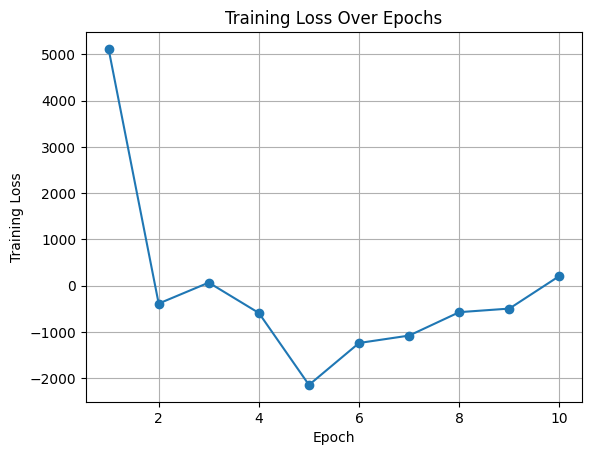

In [4]:
import torch
from torchvision import datasets, transforms
import pytorch_lightning as pl
import matplotlib.pyplot as plt

# Define a transformation to normalize the data
# Define a transformation to normalize the data and flatten it
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the image
])


# Define a custom callback to record training losses
class LossCallback(pl.Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        # Access the training loss and append it to the list
        train_loss = trainer.callback_metrics['train_loss'].item()
        self.train_losses.append(train_loss)

# Load the MNIST dataset
mnist_train = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)

# Define hyperparameters
latent_dims = 2
hidden_layer_size = 256
hidden_layer_size2 = 128
learning_rate = 0.001
batch_size = 64
beta = 1.0

# Initialize the VAE_normal model
vae_model = VAE_normal(dataloader, nitems=28*28, latent_dims=latent_dims,
                       hidden_layer_size=hidden_layer_size, hidden_layer_size2=hidden_layer_size2,
                       learning_rate=learning_rate, batch_size=batch_size, beta=beta)

loss_callback = LossCallback()

# Create a PyTorch Lightning Trainer with the custom callback
trainer = pl.Trainer(max_epochs=10, callbacks=[loss_callback])  # You can adjust max_epochs and other parameters

# Start training
trainer.fit(vae_model, dataloader)

# Plot the training loss over epochs
plt.plot(range(1, 11), loss_callback.train_losses, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

In [5]:
theta = torch.normal(torch.zeros(2))
theta.requires_grad = True
FIM = vae_model.compute_information(theta)[0]
det = torch.det(FIM)
det

NameError: name 'roots_hermite' is not defined

tensor([1.0730, 0.6529])

In [98]:
batch = next(iter(dataloader))[0]
out = vae_model(batch).detach()

In [89]:
import matplotlib.pyplot as plt
import numpy as np

def plot_tensor(tensor_1d, title="Image"):
    """
    Plots a 1D tensor as a 28x28 image.
    
    Args:
        tensor_1d (torch.Tensor): 1D tensor of size 784 (28x28).
        title (str): Title for the plot.
    """
    # Reshape the 1D tensor into a 28x28 matrix
    tensor_2d = tensor_1d.reshape(28, 28)
    
    # Create a figure and axis for the plot
    plt.figure(figsize=(5, 5))
    plt.imshow(tensor_2d, cmap='gray')
    plt.title(title)
    plt.axis('off')  # Turn off axis labels and ticks
    plt.show()

# Example usage:
# Assuming you have a 1D tensor 'image_tensor' of size 784
# plot_1d_tensor_as_image(image_tensor, title="My Image")



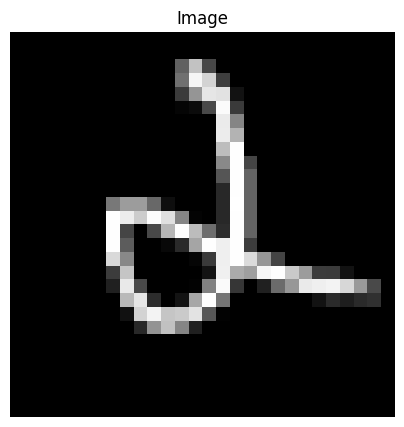

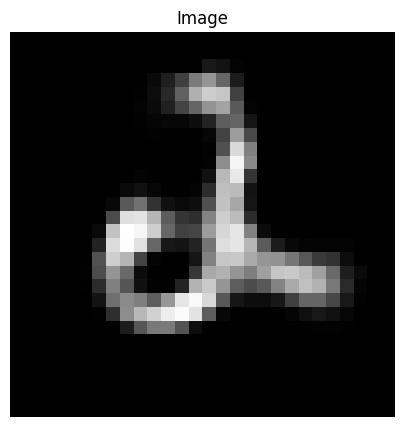

In [100]:
image = 10
plot_tensor(batch[image, :])
plot_tensor(out[image, :])

In [68]:
z, sigma = vae_model.encoder(batch)
z.mean(0)
sigma.mean(0)

tensor([-3.6145, -4.2998, -3.7968, -3.6091, -3.8528, -4.0346, -3.8041, -4.0474,
        -3.5548, -4.1812, -3.4278, -4.4764, -3.8327, -3.0677, -3.6354, -4.0680,
        -3.7702, -3.6134, -3.5762, -3.5784], grad_fn=<MeanBackward1>)

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from torch.utils.data import DataLoader, Dataset
import sys
import time
import os

# set working directory to source file location
#abspath = os.path.abspath(__file__)
#dname = os.path.dirname(abspath)
#os.chdir(dname)

# set device to gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load configurations
with open("./config.yml", "r") as f:
    cfg = yaml.safe_load(f)
    cfg = cfg['configs']



theta=np.random.normal(0,1,cfg['N']*cfg['mirt_dim']).reshape((cfg['N'], cfg['mirt_dim']))
a = np.random.uniform(.5, 2, 28 * cfg['mirt_dim']).reshape((28, cfg['mirt_dim']))  # draw discrimination parameters from uniform distribution
b = np.linspace(-2, 2, 28, endpoint=True)  # eqally spaced values between -2 and 2 for the difficulty
exponent = np.dot(theta, a.T) + b
prob = np.exp(exponent) / (1 + np.exp(exponent))
data = np.random.binomial(1, prob).astype(float)

# introduce missingness
#np.random.seed(cfg['iteration'])
#indices = np.random.choice(data.shape[0]*data.shape[1], replace=False, size=int(data.shape[0]*data.shape[1]*cfg['missing_percentage']))
#data[np.unravel_index(indices, data.shape)] = float('nan')
#data = torch.Tensor(data)

# initialise model and optimizer
logger = CSVLogger("logs", name='simfit', version=0)
trainer = Trainer(fast_dev_run=cfg['single_epoch_test_run'],
                  max_epochs=1500,#cfg['max_epochs'],
                  enable_checkpointing=False,
                  logger=False,
                  callbacks=[EarlyStopping(monitor='train_loss', min_delta=cfg['min_delta'], patience=cfg['patience'], mode='min')])

dataset = SimDataset(data)
train_loader = DataLoader(dataset, batch_size=cfg['batch_size'], shuffle=False)
vae = VAE(nitems=data.shape[1],
            dataloader=train_loader,
            latent_dims=cfg['mirt_dim'],
            hidden_layer_size=cfg['hidden_layer_size'],
            hidden_layer_size2=cfg['hidden_layer_size2'],
            learning_rate=cfg['learning_rate'],
            batch_size=data.shape[0]
)



GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [21]:
start = time.time()
trainer.fit(vae)
runtime = time.time()-start


  | Name    | Type          | Params
------------------------------------------
0 | encoder | Encoder       | 1.6 K 
1 | sampler | SamplingLayer | 0     
2 | decoder | Decoder       | 112   
------------------------------------------
1.7 K     Trainable params
0         Non-trainable params
1.7 K     Total params
0.007     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [8]:
data, mask = next(iter(train_loader))
theta_est, _ = vae.encoder(data)



In [10]:
theta = torch.normal(torch.zeros(cfg['mirt_dim']))
theta.requires_grad = True
FIM = vae.compute_information(theta)[0]
FIM

array([[ 0.05239055, -0.07040454,  0.04420692],
       [-0.07040454,  0.09461246, -0.05940706],
       [ 0.04420692, -0.05940706,  0.03730162]], dtype=float32)

In [11]:
torch.det(FIM)

TypeError: det(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [12]:
import torch

# Example input tensor
tensor = torch.tensor([[1, 2, 3], [4,5,6]])

# Reshape the input tensor to add a new axis
if tensor.ndim == 1:
    tensor = tensor.unsqueeze(0) 
tensor = tensor[:, :, None]
# Perform element-wise multiplication
result = tensor * tensor.transpose(1, 2)

print(result)

tensor([[[ 1,  2,  3],
         [ 2,  4,  6],
         [ 3,  6,  9]],

        [[16, 20, 24],
         [20, 25, 30],
         [24, 30, 36]]])


In [240]:
FIM

tensor([[ 4.1921e-04, -3.4186e-03, -3.9359e-03, -2.5715e-02,  6.6176e-04,
          2.0714e-05, -2.3419e-03,  9.1999e-04,  1.2759e-03,  2.2611e-04],
        [-3.4186e-03,  2.7879e-02,  3.2097e-02,  2.0970e-01, -5.3966e-03,
         -1.6892e-04,  1.9098e-02, -7.5025e-03, -1.0405e-02, -1.8439e-03],
        [-3.9359e-03,  3.2097e-02,  3.6954e-02,  2.4143e-01, -6.2132e-03,
         -1.9448e-04,  2.1988e-02, -8.6377e-03, -1.1979e-02, -2.1229e-03],
        [-2.5715e-02,  2.0970e-01,  2.4143e-01,  1.5774e+00, -4.0593e-02,
         -1.2706e-03,  1.4366e-01, -5.6433e-02, -7.8262e-02, -1.3870e-02],
        [ 6.6176e-04, -5.3966e-03, -6.2132e-03, -4.0593e-02,  1.0446e-03,
          3.2699e-05, -3.6970e-03,  1.4523e-03,  2.0141e-03,  3.5693e-04],
        [ 2.0714e-05, -1.6892e-04, -1.9448e-04, -1.2706e-03,  3.2699e-05,
          1.0235e-06, -1.1572e-04,  4.5458e-05,  6.3042e-05,  1.1172e-05],
        [-2.3419e-03,  1.9098e-02,  2.1988e-02,  1.4366e-01, -3.6970e-03,
         -1.1572e-04,  1.3083e-0

In [13]:
def iteminfomat(theta, a, d):
    dim = theta.size(0)  # latent dimension

    # get probability of a correct response
    P = torch.sigmoid(torch.dot(a, theta) + d)
    Q = 1 - P

    # calculate information matrix
    info_mat = torch.zeros((dim, dim))
    for r in range(dim):
        for s in range(dim):
            print(r)
            print(s)
            info_mat[r, s] = a[r] * a[s] * Q * P

    return info_mat

In [14]:
a = vae.decoder.linear.weight
d = vae.decoder.linear.bias
a = a[0,:]
d = d[0]

#theta = torch.zeros(10)
dim = theta.size(0)  # latent dimension

# get probability of a correct response
P = torch.sigmoid(torch.dot(a, theta) + d)
Q = 1 - P

# calculate information matrix
info_mat = torch.zeros((dim, dim))
for r in range(dim):
    for s in range(dim):
        info_mat[r, s] = a[r] * a[s] * Q * P

info_mat

tensor([[ 0.0524, -0.0704,  0.0442],
        [-0.0704,  0.0946, -0.0594],
        [ 0.0442, -0.0594,  0.0373]], grad_fn=<CopySlices>)

In [15]:
a = vae.decoder.linear.weight.detach().numpy()
d = vae.decoder.linear.bias.detach().numpy()
np.savetxt('/Users/karel/Documents/GitHub/Information-VAE/data/a.csv', a, delimiter=',')
np.savetxt('/Users/karel/Documents/GitHub/Information-VAE/data/d.csv', d, delimiter=',')

## Simulation data and fit mdel

In [16]:
# simulate data
N = 1000
nitems = 30
mirt_dim=3

theta =np.random.normal(0,1,N*mirt_dim).reshape((N,mirt_dim))
a = np.random.uniform(.5, 2, nitems * mirt_dim).reshape((nitems, mirt_dim))  # draw discrimination parameters from uniform distribution
b = np.linspace(-2, 2, nitems, endpoint=True)  # eqally spaced values between -2 and 2 for the difficulty
exponent = np.dot(theta, a.T) + b

prob = np.exp(exponent) / (1 + np.exp(exponent))
data = np.random.binomial(1, prob).astype(float)

# Train initial model
logger = CSVLogger("logs", name='simfit', version=0)
trainer = Trainer(fast_dev_run=cfg['single_epoch_test_run'],
                  max_epochs=1500,#cfg['max_epochs'],
                  enable_checkpointing=False,
                  logger=False,
                  callbacks=[EarlyStopping(monitor='train_loss', min_delta=cfg['min_delta'], patience=cfg['patience'], mode='min')])

dataset = SimDataset(data)
train_loader = DataLoader(dataset, batch_size=cfg['batch_size'], shuffle=False)
vae = VAE(nitems=data.shape[1],
            dataloader=train_loader,
            latent_dims=cfg['mirt_dim'],
            hidden_layer_size=cfg['hidden_layer_size'],
            hidden_layer_size2=cfg['hidden_layer_size2'],
            learning_rate=cfg['learning_rate'],
            batch_size=data.shape[0]
)

start = time.time()
trainer.fit(vae)
runtime = time.time()-start

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type          | Params
------------------------------------------
0 | encoder | Encoder       | 1.7 K 
1 | sampler | SamplingLayer | 0     
2 | decoder | Decoder       | 120   
------------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [406]:
cfg['mirt_dim']

3

## Simulation study for new participants

In [22]:
def predict_mirt(a, d, theta):
    print(theta.shape)
    prob = torch.exp(a@theta.T+d) / (1 + torch.exp(a@theta.T+d))
    return prob.T

def simulate_cat(true_model, n_pers):
    # simualte true ability values
    n_item = true_model.nitems
    mirt_dim = vae.encoder.densem.out_features
    theta = torch.normal(torch.zeros((n_pers, mirt_dim)), torch.ones((n_pers, mirt_dim)))
    a = true_model.decoder.linear.weight.detach()
    d = true_model.decoder.linear.bias.detach()
    # sample responses given true model
    true_prob = predict_mirt(a, d, theta.T)
    data = torch.bernoulli(true_prob)
    
    error_mat_theta = np.empty((n_pers, n_item))
    prob_mat = np.empty((n_pers, n_item))
    
    for p in range(n_pers):
        theta_est = torch.zeros(mirt_dim)
        theta_est.requires_grad = True
        theta_estimates = np.empty((n_item, mirt_dim))
        answered = np.zeros(n_item, dtype=bool)
        
        
        for i in range(n_item):
            # compute item information matrices with respect to current theta estimate
            FIMs = true_model.compute_information(theta_est)
            # compute current test information matrix
            TIM = np.zeros_like(FIMs[0])
            for m in range(len(FIMs)):
                if answered[i]:
                    TIM += FIMs[m]
            
            
            dets = [np.linalg.det(TIM+FIM) for FIM in FIMs]

            next_item_ix = dets.index(min(dets))
            
            answered[next_item_ix] = True
            # 
            prob_mat[p, i] = true_prob[p, next_item_ix]
            resp_patt = data[p, ]
            resp_patt[~answered] = np.nan
            
            theta_est = true_model.encoder(torch.Tensor(resp_patt))
            
            
            vae
            break


In [18]:
ans = np.array([True, False, False, True, True])
rp = np.array([1,0,1,1,0], dtype=float)

rp[~ans] = np.nan
rp

array([ 1., nan, nan,  1.,  0.])

In [338]:
# Create a tensor with the desired pattern
tensor = torch.cat((torch.ones(8, dtype=torch.bool), torch.zeros(20, dtype=torch.bool)))


In [ ]:
simulate_cat